In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col

from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors

spark = SparkSession.Builder().appName('DDAM_Project_north').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 08:22:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/North_Incidents_Cleaned.csv')

In [3]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T

23/12/15 08:23:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0
Severity,0
Start_Time,0
Start_Lat,0
Start_Lng,0
Distance_mi,0
City,0
County,0
State,0
Temperature_F,0
Wind_Chill_F,0


In [4]:
df=df.drop('Wind_Chill_F')

preparing data

In [5]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
#df_class.show()
colonne_booleane = ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))

#df_class.show()
from pyspark.sql.functions import when, count, isnull
df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))
indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
df_class = indexer.fit(df_class).transform(df_class)

In [6]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_vector = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_1hot")
df_class = onehotencoder_vector.fit(df_class).transform(df_class)
df_class.printSchema()
df_class=df_class.drop('Weather_Condition')
#df_class.show()
df_class=df_class.drop('Weather_Condition_Indexed')

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance_mi: double (nullable = true)
 |-- Temperature_F: double (nullable = true)
 |-- Humidity_perc: double (nullable = true)
 |-- Visibility_mi: double (nullable = true)
 |-- Wind_Speed_mph: double (nullable = true)
 |-- Precipitation_in: double (nullable = true)
 |-- Amenity: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Give_Way: integer (nullable = true)
 |-- Junction: integer (nullable = true)
 |-- No_Exit: integer (nullable = true)
 |-- Railway: integer (nullable = true)
 |-- Roundabout: integer (nullable = true)
 |-- Station: integer (nullable = true)
 |-- Stop: integer (nullable = true)
 |-- Traffic_Calming: integer (nullable = true)
 |-- Traffic_Signal: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Working_Weekend: integer (nullable = false)
 |-- Astronomical_

In [7]:
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Working_Weekend")
print(num_col)

['Severity', 'Start_Lat', 'Start_Lng', 'Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in', 'Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'month', 'hour', 'Astronomical_Twilight', 'Weather_Condition_1hot']


In [8]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_class)

classificationData = output_dataset.select("features", "Working_Weekend")

#classificationData.show(truncate=False)
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)
from pyspark.sql import functions as F

In [9]:
g=trainingData.groupBy('Working_Weekend').agg(F.count('Working_Weekend').alias('Count'))
g=g.sort('Working_Weekend')
g.show()

+---------------+-----+
|Working_Weekend|Count|
+---------------+-----+
|              0|46859|
|              1|11484|
+---------------+-----+



In [10]:
g_p=g.toPandas()

In [11]:
g_p
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]

In [12]:
trainingData.show()

+--------------------+---------------+
|            features|Working_Weekend|
+--------------------+---------------+
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              1|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              1|
|(27,[0,1,2,3,4,5,...|              1|
|(27,[0,1,2,3,4,5,...|              1|
|(27,[0,1,2,3,4,5,...|              1|
|(27,[0,1,2,3,4,5,...|              0|
|(27,[0,1,2,3,4,5,...|              1|
+--------------------+---------------+
only showing top 20 rows



# Random Forest

In [13]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=5,maxDepth=15)
 
 
# Train model.  This also runs the indexers.
model = rf.fit(trainingData)
 
 
# Make predictions.
predictions = model.transform(testData)
 
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")
 
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)
 
list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem
 
avg_f1=sum_/2
print('----------------------')
 
print("avg_F1-Score: {:.2%}".format(avg_f1))

23/12/15 09:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1296.9 KiB
23/12/15 09:05:42 WARN DAGScheduler: Broadcasting large task binary with size 1734.2 KiB
23/12/15 09:05:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/15 09:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1433.4 KiB


0.8295217461081689
Test Error = 0.170478


23/12/15 09:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1421.8 KiB
23/12/15 09:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1433.2 KiB


Precision for class  0 : 83.25%
Recall for class  0 : 98.53%
avg_F1-Score for class  0 : 90.25%
----------------------------
Precision for class  1 : 77.54%
Recall for class  1 : 20.42%
avg_F1-Score for class  1 : 32.33%
----------------------------
[0.9024765314788038, 0.3232998885172798]
----------------------
avg_F1-Score: 61.29%


<Axes: >

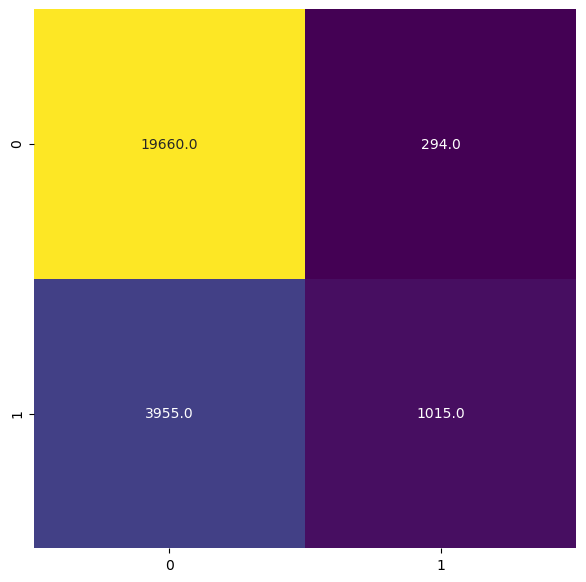

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [17]:
model.featureImportances

SparseVector(27, {0: 0.0121, 1: 0.098, 2: 0.104, 3: 0.0814, 4: 0.1307, 5: 0.0938, 6: 0.0496, 7: 0.0943, 8: 0.024, 9: 0.0014, 10: 0.0035, 11: 0.0005, 12: 0.0072, 13: 0.0005, 14: 0.0017, 16: 0.0017, 17: 0.002, 19: 0.0049, 20: 0.0868, 21: 0.1341, 22: 0.0237, 23: 0.0143, 24: 0.0127, 25: 0.0125, 26: 0.0045})

# Decision tree

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(trainingData)

In [19]:
dt.featureImportances

SparseVector(27, {1: 0.0228, 2: 0.0268, 3: 0.0461, 4: 0.1033, 7: 0.1089, 20: 0.0647, 21: 0.6115, 25: 0.016})

In [20]:
# Make predictions.
predictions = dt.transform(testData)

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.8039640507141711
Test Error = 0.196036


In [22]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 80.53%
Recall for class  0 : 99.59%
avg_F1-Score for class  0 : 89.05%
----------------------------
Precision for class  1 : 67.07%
Recall for class  1 : 3.32%
avg_F1-Score for class  1 : 6.33%
----------------------------
[0.8905269761606022, 0.06326687116564417]
----------------------
avg_F1-Score: 47.69%


<Axes: >

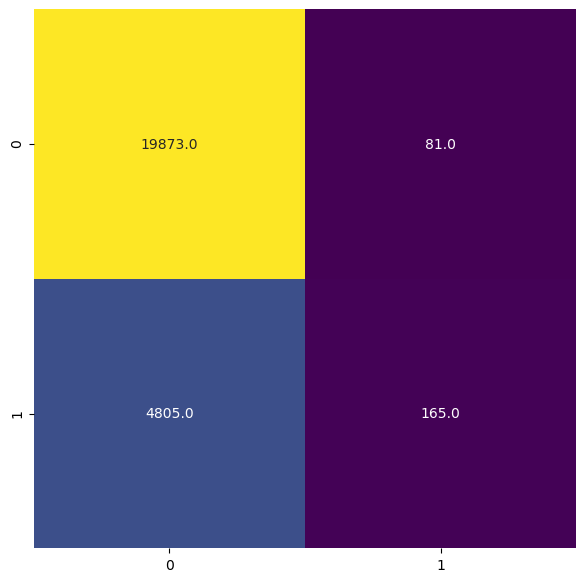

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

# Hyperparameter Tuning Decision Tree

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt
n=trainingData.count()

0.8002728294013802
Test Error = 0.199727


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 80.53%
Recall for class  0 : 98.98%
avg_F1-Score for class  0 : 88.81%
----------------------------
Precision for class  1 : 48.99%
Recall for class  1 : 3.92%
avg_F1-Score for class  1 : 7.27%
----------------------------
[0.8880845323741007, 0.0726527570789866]
----------------------
avg_F1-Score: 48.04%


<Axes: >

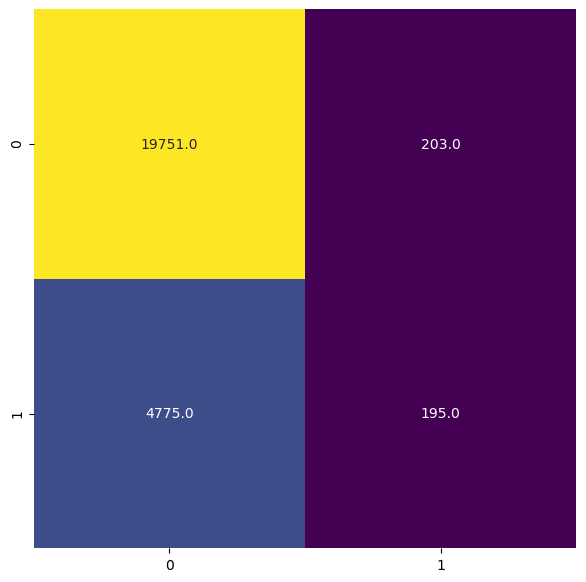

In [25]:
ax_depth=[5,15,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']
# Creiamo la colonna 'weights' basata sulla frequenza delle classi
trainingData_w = trainingData.withColumn("weights", when(trainingData["Working_Weekend"] == 0 , 1)#Calcolo del peso per la classe 0
    .when(trainingData["Working_Weekend"] == 1, n_0/n_1)  # Calcolo del peso per la classe 1

)
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=10, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.8005938051677098
Test Error = 0.199406


Precision for class  0 : 80.06%
Recall for class  0 : 100.00%
avg_F1-Score for class  0 : 88.93%
----------------------------
Precision for class  1 : 0.00%
Recall for class  1 : 0.00%
avg_F1-Score for class  1 : 0.00%
----------------------------
[0.8892553144079504, 0.0]
----------------------
avg_F1-Score: 44.46%


<Axes: >

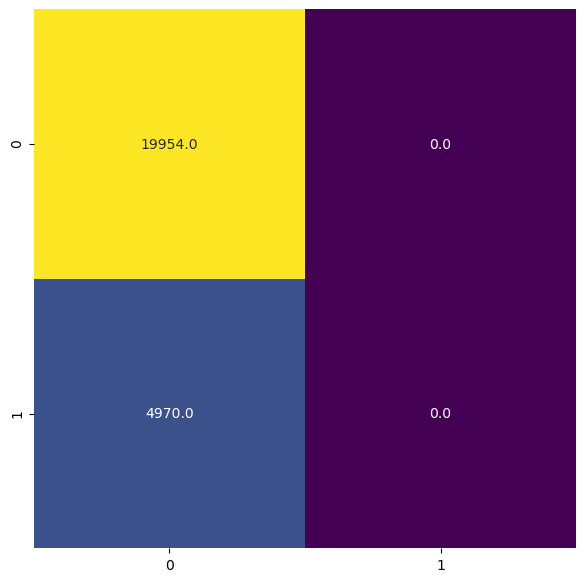

In [26]:
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=15, maxBins=32, 
                            minInstancesPerNode=round(0.02*n))
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.8002728294013802
Test Error = 0.199727


Precision for class  0 : 80.53%
Recall for class  0 : 98.98%
avg_F1-Score for class  0 : 88.81%
----------------------------
Precision for class  1 : 48.99%
Recall for class  1 : 3.92%
avg_F1-Score for class  1 : 7.27%
----------------------------
[0.8880845323741007, 0.0726527570789866]
----------------------
avg_F1-Score: 48.04%


<Axes: >

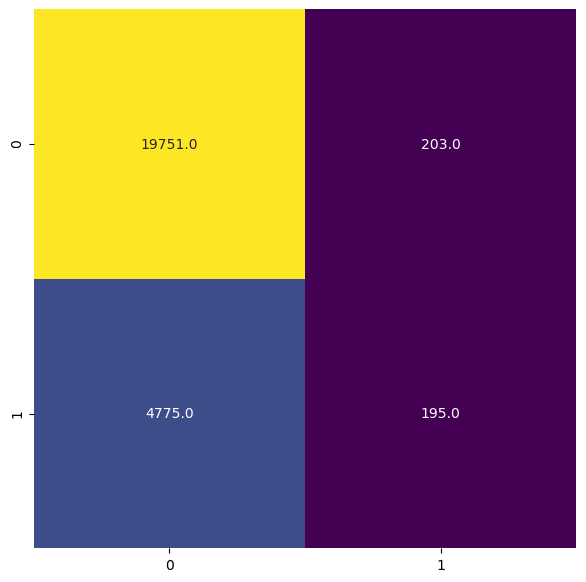

In [27]:
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=25, maxBins=64,
                            minInstancesPerNode=round(0.005*n), impurity='entropy' )
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

0.6089311506981223
Test Error = 0.391069


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 86.01%
Recall for class  0 : 61.09%
avg_F1-Score for class  0 : 71.44%
----------------------------
Precision for class  1 : 27.78%
Recall for class  1 : 60.10%
avg_F1-Score for class  1 : 38.00%
----------------------------
[0.71439036539983, 0.38000127218370333]
----------------------
avg_F1-Score: 54.72%


<Axes: >

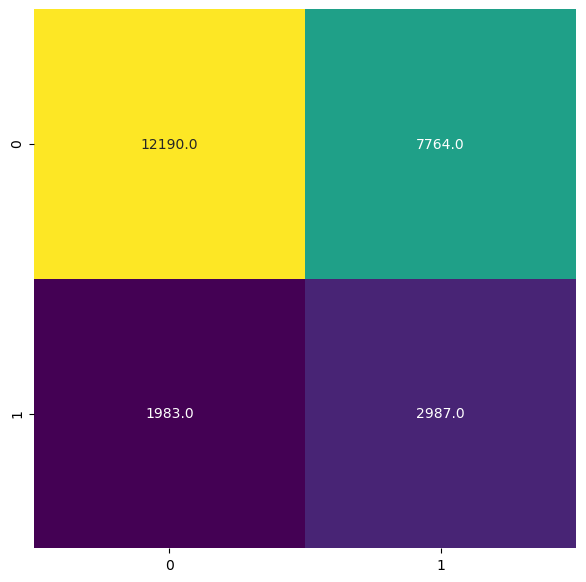

In [28]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Working_Weekend"] == 0 , 1)#Calcolo del peso per la classe 0
    .when(trainingData["Working_Weekend"] == 1, n_0/n_1)  # Calcolo del peso per la classe 1

)

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=10, maxBins=32, 
                            minInstancesPerNode=round(0.02*n), weightCol='weights')
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.800032097576633
Test Error = 0.199968


Precision for class  0 : 81.26%
Recall for class  0 : 97.52%
avg_F1-Score for class  0 : 88.65%
----------------------------
Precision for class  1 : 49.28%
Recall for class  1 : 9.68%
avg_F1-Score for class  1 : 16.18%
----------------------------
[0.8864744202997585, 0.16178943827783385]
----------------------
avg_F1-Score: 52.41%


<Axes: >

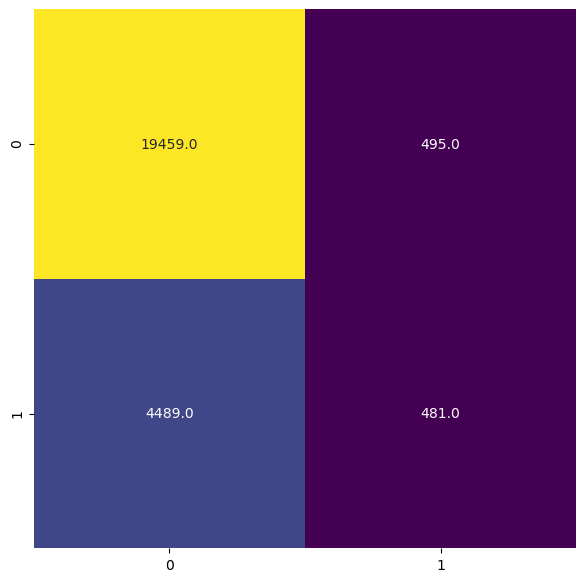

In [29]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Working_Weekend"] == 0 , 1)#Calcolo del peso per la classe 0
    .when(trainingData["Working_Weekend"] == 1, 1.2)  # Calcolo del peso per la classe 1

)

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=25, maxBins=64,
                            minInstancesPerNode=round(0.005*n), impurity='entropy', weightCol='weights' )
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

# undersampling

DECISION TREE

In [30]:
train_und = trainingData.sampleBy('Working_Weekend', fractions={0:n_1/n_0 ,1: 1})
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(train_und)

In [31]:
dt.featureImportances

SparseVector(27, {0: 0.0278, 1: 0.0077, 2: 0.0135, 3: 0.1263, 4: 0.0169, 5: 0.007, 6: 0.092, 7: 0.0498, 14: 0.0018, 20: 0.0052, 21: 0.652})

In [32]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.5978574867597496
Test Error = 0.402143


In [33]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 85.56%
Recall for class  0 : 59.87%
avg_F1-Score for class  0 : 70.45%
----------------------------
Precision for class  1 : 26.95%
Recall for class  1 : 59.44%
avg_F1-Score for class  1 : 37.08%
----------------------------
[0.7044844768110388, 0.37084928755257046]
----------------------
avg_F1-Score: 53.77%


<Axes: >

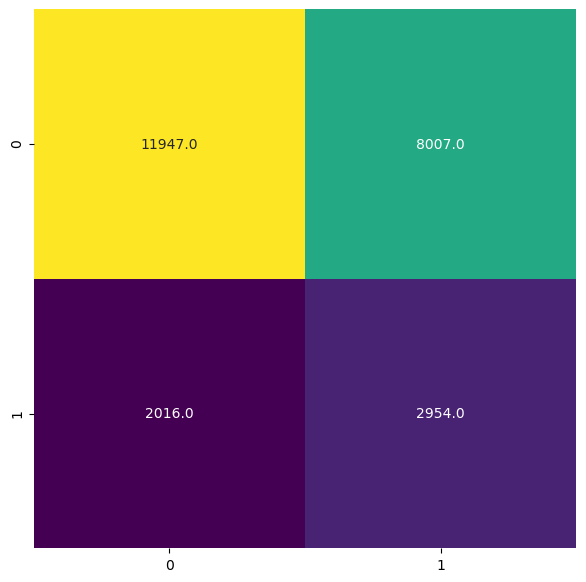

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

RANDOM FOREST

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=5,maxDepth=15)
 
 
# Train model.  This also runs the indexers.
model = rf.fit(train_und)
 
 
# Make predictions.
predictions = model.transform(testData)
 
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")
 
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)
 
list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem
 
avg_f1=sum_/2
print('----------------------')
 
print("avg_F1-Score: {:.2%}".format(avg_f1))

23/12/15 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1079.9 KiB
23/12/15 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1380.2 KiB
23/12/15 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1700.6 KiB
23/12/15 09:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1140.7 KiB
23/12/15 09:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1129.1 KiB


0.6864066762959397
Test Error = 0.313593


23/12/15 09:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1140.5 KiB


Precision for class  0 : 91.68%
Recall for class  0 : 66.90%
avg_F1-Score for class  0 : 77.35%
----------------------------
Precision for class  1 : 36.27%
Recall for class  1 : 75.63%
avg_F1-Score for class  1 : 49.03%
----------------------------
[0.7735411716984412, 0.4902830311725578]
----------------------
avg_F1-Score: 63.19%


In [37]:
model.featureImportances

SparseVector(27, {0: 0.0226, 1: 0.1119, 2: 0.1073, 3: 0.0966, 4: 0.1163, 5: 0.0888, 6: 0.0474, 7: 0.0836, 8: 0.0165, 9: 0.0009, 10: 0.004, 11: 0.0004, 12: 0.0069, 13: 0.0001, 14: 0.0011, 16: 0.0011, 17: 0.0015, 18: 0.0, 19: 0.006, 20: 0.0862, 21: 0.1342, 22: 0.0258, 23: 0.0103, 24: 0.0117, 25: 0.0137, 26: 0.0051})

# Oversampling

DECISION TREE

In [38]:
under_1=trainingData.filter(col('Working_Weekend') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)


In [39]:
oversample_1=trainingData.filter(col('Working_Weekend') == 1)
num_campioni_da_generare = n_0
num_campioni_da_generare=(num_campioni_da_generare-n_1)/n_1 #percentuale 
#print(num_campioni_da_generare)
full_1=oversample_1
#print(full.count())
while num_campioni_da_generare>1:
    oversample_1= oversample_1.unionAll(full_1)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
df_minority_oversampled = full_1.sample(True, num_campioni_da_generare, seed=42)

oversample_1 = oversample_1.unionAll(df_minority_oversampled)

2.080372692441658
1.080372692441658
0.0803726924416579


In [40]:
df_over=oversample_1.unionAll(trainingData.filter(col('Working_Weekend') == 0))

In [41]:
from pyspark.sql import functions as F
g=df_over.groupBy('Working_Weekend').agg(F.count('Working_Weekend').alias('Working_Weekend'))
g=g.sort('Working_Weekend')
g.show()

+---------------+---------------+
|Working_Weekend|Working_Weekend|
+---------------+---------------+
|              0|          46859|
|              1|          46853|
+---------------+---------------+



In [42]:
train_over=df_over
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(train_over)

In [43]:
dt.featureImportances

SparseVector(27, {0: 0.0279, 1: 0.013, 2: 0.0221, 3: 0.1277, 4: 0.003, 5: 0.0172, 6: 0.077, 7: 0.0409, 20: 0.0163, 21: 0.6494, 25: 0.0054})

In [44]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.6263842079922965
Test Error = 0.373616


In [45]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

Precision for class  0 : 85.47%
Recall for class  0 : 64.25%
avg_F1-Score for class  0 : 73.36%
----------------------------
Precision for class  1 : 28.12%
Recall for class  1 : 56.16%
avg_F1-Score for class  1 : 37.48%
----------------------------
[0.7335927218630199, 0.37478179132536593]
----------------------
avg_F1-Score: 55.42%


<Axes: >

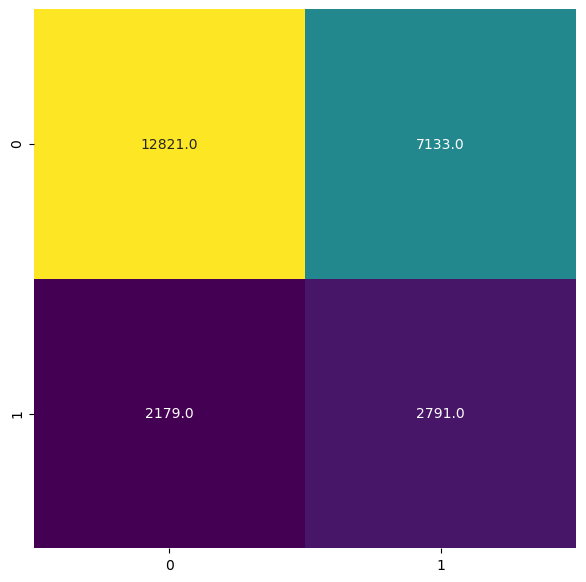

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

RANDOM FOREST

In [47]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=10)


# Train model.  This also runs the indexers.
model = rf.fit(train_over)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
#predictions.select("predictedLabel", "Severity", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Working_Weekend", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))

Test Accuracy = 0.655513


In [48]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 86.05%
Recall for class  0 : 68.00%
avg_F1-Score for class  0 : 75.96%
----------------------------
Precision for class  1 : 30.25%
Recall for class  1 : 55.73%
avg_F1-Score for class  1 : 39.22%
----------------------------
[0.7596439169139466, 0.392184624097409]
----------------------
avg_F1-Score: 57.59%


<Axes: >

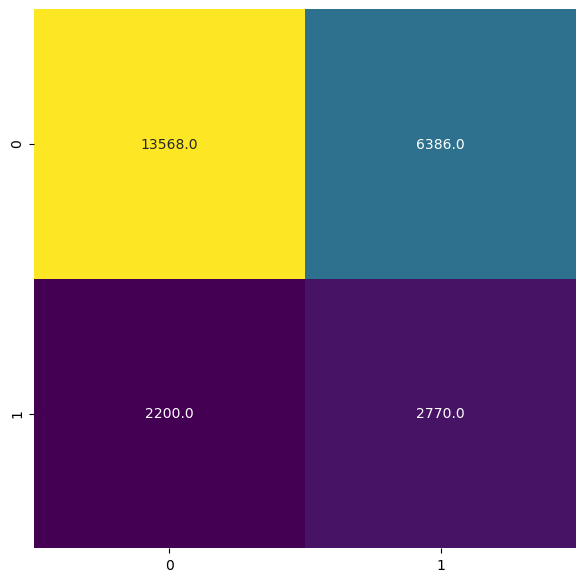

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [50]:
model.featureImportances

SparseVector(27, {0: 0.0898, 1: 0.0637, 2: 0.0589, 3: 0.1317, 4: 0.0966, 5: 0.009, 6: 0.0564, 7: 0.0123, 8: 0.0066, 10: 0.0008, 11: 0.0001, 12: 0.001, 16: 0.0006, 17: 0.0001, 19: 0.0061, 20: 0.0565, 21: 0.191, 22: 0.1988, 23: 0.0054, 24: 0.0048, 25: 0.0099})